In [190]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import timedelta, date
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

In [191]:
#Cargo datos de viajes
tripsDf = pd.read_csv("data/trip.csv")
#Cargo datos de estaciones
stationsDf = pd.read_csv('data/station.csv')

In [192]:
#Analizo los tipos de datos de trips
tripsDf.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

In [193]:
#Convierto datos de fechas a datetime
tripsDf['start_date'] = pd.to_datetime(tripsDf['start_date'], format = "%m/%d/%Y %H:%M")
tripsDf['end_date'] = pd.to_datetime(tripsDf['end_date'], format = "%m/%d/%Y %H:%M")

In [194]:
#Creo columna solo con datos de la fecha de inicio
tripsDf['date'] = tripsDf['start_date'].map(lambda x: x.date())

In [195]:
#Agrego columnas con el año y el mes
tripsDf['year'] = tripsDf['date'].map(lambda x: x.year)
tripsDf['month'] = tripsDf['date'].map(lambda x: x.month)
tripsDf['day'] = tripsDf['date'].map(lambda x: x.day)

In [196]:
#Agrego columnas solo con el día, y otro con formato año-mes
tripsDf['year-month'] = tripsDf['start_date'].map(lambda x: x.strftime('%Y-%m'))

In [197]:
#Analizo los datos de stations
stationsDf.dtypes

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object

In [198]:
#Cambio el nombre de la columna id a station_id por claridad
stationsDf.rename(columns={'id':'station_id'}, inplace=True)

# ¿Cómo evoluciona con el tiempo la cantidad de viajes?

Se realizará un análisis de la cantidad de viajes utilizando los datos de los mismos entre Agosto del 2013 y Agosto del 2015, con el fin de determinar cómo se comporta la demanda del servicio en el tiempo.

### Top 5 de días con más viajes

In [199]:
#Viajes por fecha
tripsPerDay = pd.DataFrame({'count' : tripsDf.groupby(['date']).size()}).reset_index()

In [200]:
#Top 5 de días con más viajes
tripsPerDay.sort_values(by='count', ascending=False).head(5)

,date,count
382,2014-09-15,1516
362,2014-08-26,1513
426,2014-10-29,1496
411,2014-10-14,1496
363,2014-08-27,1479


### Cantidad de viajes, mes a mes

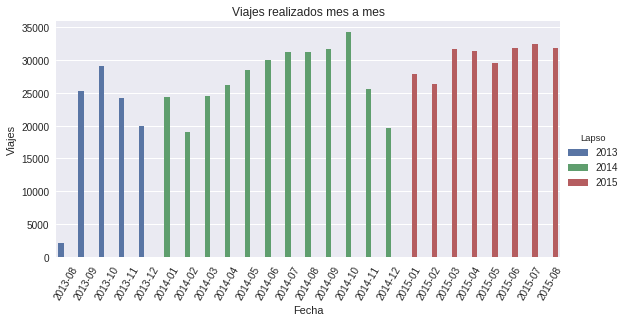

In [201]:
#Plot de viajes por mes
monthlyTrips = tripsDf
monthlyTrips = pd.DataFrame({'count' : tripsDf.groupby(['year', 'month', 'year-month']).size()}).reset_index()
monthlyTrips = monthlyTrips.loc[:, ['count', 'year-month', 'year', 'month']]
monthlyTrips.rename(columns={'count':'Viajes', 'month':'Mes', 'year':'Lapso', 'year-month':'Fecha'}, inplace=True)

g = sns.factorplot(x='Fecha', y='Viajes', hue='Lapso', data=monthlyTrips, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Viajes realizados mes a mes')
g.set_xticklabels(rotation=60)

### Comparación interanual de viajes mensuales

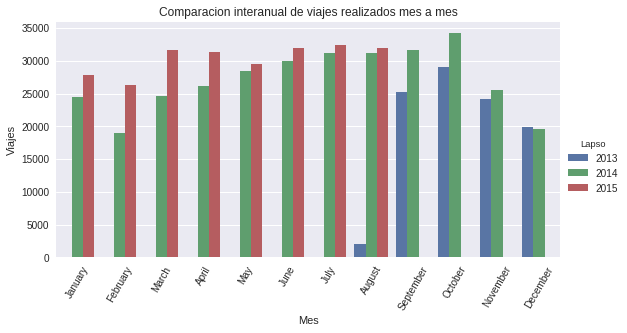

In [202]:
#Plot de viajes por mes
monthlyTrips = tripsDf
monthlyTrips = pd.DataFrame({'count' : tripsDf.groupby(['year', 'month','date']).size()}).reset_index()
monthlyTrips['month_name'] = monthlyTrips['date'].map(lambda x: x.strftime('%B'))
monthlyTrips = monthlyTrips.groupby(['month', 'year', 'month_name']).sum()
monthlyTrips = monthlyTrips.reset_index()

monthlyTrips.rename(columns={'count':'Viajes', 'month_name':'Mes', 'year':'Lapso'}, inplace=True)

g = sns.factorplot(x='Mes', y='Viajes', hue='Lapso', data=monthlyTrips, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Comparacion interanual de viajes realizados mes a mes')
g.set_xticklabels(rotation=60)

### Viajes por año

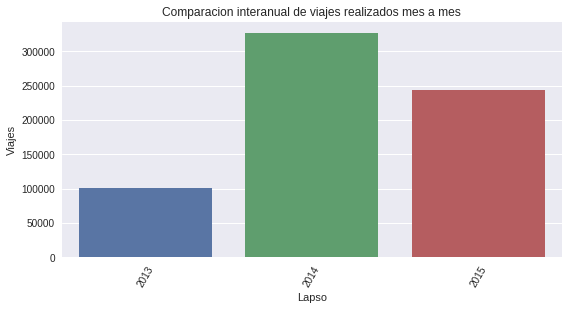

In [203]:
#Viajes por año
yearTrips = tripsDf
yearTrips = pd.DataFrame({'count' : tripsDf.groupby(['year']).size()}).reset_index()
yearTrips.rename(columns={'count':'Viajes', 'year':'Lapso'}, inplace=True)

g = sns.factorplot(x='Lapso', y='Viajes', data=yearTrips, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Comparacion interanual de viajes realizados mes a mes')
g.set_xticklabels(rotation=60)

### Viajes promedio por año

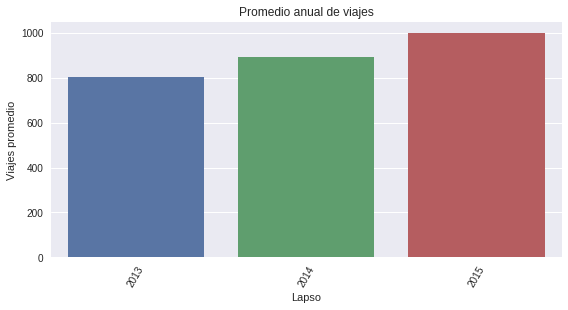

In [204]:
#Viajes promedio por año
yearAverageTrips = pd.DataFrame({'count' : tripsDf.groupby(['year']).size(),\
                             'days' : tripsDf.groupby(['year']).date.nunique(),\
                             'average_trips' : tripsDf.groupby(['year']).size()/tripsDf.groupby(['year']).date.nunique()}).reset_index()

yearAverageTrips.rename(columns={'year':'Lapso', 'average_trips':'Viajes promedio'}, inplace=True)

g = sns.factorplot(x='Lapso', y='Viajes promedio', data=yearAverageTrips, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Promedio anual de viajes')
g.set_xticklabels(rotation=60)

# ¿Cómo se satisface la demanda del servicio?

Se analizará utilizando los datos minuto a minuto de las estaciones, en cuántas oportunidades se encontraban sin bicicletas disponibles.

In [205]:
#Obtenemos los datos en los que alguna estación se quedó sin bicicletas
df = []
for chunk in pd.read_csv('data/status.csv', chunksize=1000000):
    df.append(chunk[chunk.bikes_available == 0])
emptyStationDf = pd.concat(df)

In [337]:
len(emptyStationDf)

529004

In [207]:
emptyStationDf.dtypes

station_id          int64
bikes_available     int64
docks_available     int64
time               object
dtype: object

In [208]:
#Convierto a fecha el dato de time
emptyStationDf['time'] = pd.to_datetime(emptyStationDf['time'], format = "%Y/%m/%d %H:%M:%S")

#Agrego columnas para el año, mes, día y hora
emptyStationDf['year'] = emptyStationDf['time'].map(lambda x: x.year)
emptyStationDf['month'] = emptyStationDf['time'].map(lambda x: x.month)
emptyStationDf['day'] = emptyStationDf['time'].map(lambda x: x.day)
emptyStationDf['hour'] = emptyStationDf['time'].map(lambda x: x.hour)

In [209]:
#Combino datos de estaciones vacías con los datos de las estaciones
emptyStationDf = emptyStationDf.merge(stationsDf, on='station_id')

In [210]:
emptyStationDf.head(1)

,station_id,bikes_available,docks_available,time,year,month,day,hour,name,lat,long,dock_count,city,installation_date
0,2,0,27,2013-11-03 02:00:01,2013,11,3,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013


### ¿Qué estaciones informaron más veces que no tenían bicicletas?

In [211]:
moreTimesEmpty = emptyStationDf.groupby("name", as_index=False).size()
moreTimesEmpty.name = 'count'
moreTimesEmpty = moreTimesEmpty.reset_index()

#Estaciones más veces vacías
moreTimesEmpty = moreTimesEmpty.merge(stationsDf, on='name')
moreTimesEmpty = moreTimesEmpty.loc[:, ['station_id', 'name', 'city', 'count', 'dock_count']].sort_values(by='count', ascending=False)
moreTimesEmpty.head(10)

,station_id,name,city,count,dock_count
12,45,Commercial at Montgomery,San Francisco,29198,15
28,76,Market at 4th,San Francisco,24725,19
18,48,Embarcadero at Vallejo,San Francisco,24401,15
0,62,2nd at Folsom,San Francisco,24077,19
17,60,Embarcadero at Sansome,San Francisco,23143,15
49,70,San Francisco Caltrain (Townsend at 4th),San Francisco,21726,19
22,73,Grant Avenue at Columbus Avenue,San Francisco,20739,15
11,41,Clay at Battery,San Francisco,19080,15
7,82,Broadway St at Battery St,San Francisco,17824,15
1,64,2nd at South Park,San Francisco,17111,15


### ¿En qué horarios se da mayormente que no haya bicicletas?

In [212]:
hoursEmpty = emptyStationDf.groupby("hour", as_index=False).size()
hoursEmpty.name = 'count'
hoursEmpty = hoursEmpty.reset_index()

#Estaciones más veces vacías
hoursEmpty = hoursEmpty.loc[:, ['hour', 'count']].sort_values(by='count', ascending=False)
hoursEmpty.head(10)

,hour,count
18,18,63200
9,9,50322
17,17,44140
10,10,34089
8,8,33174
19,19,29980
7,7,26784
6,6,22234
16,16,20285
11,11,19973


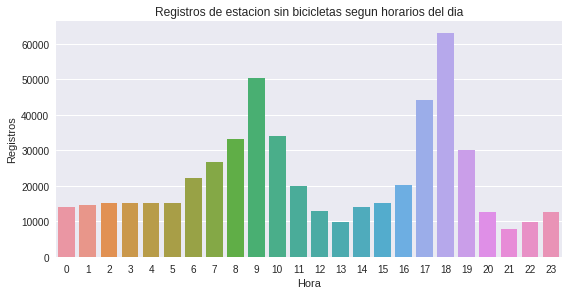

In [213]:
#Grafico de los datos de registros por hora
hoursEmpty.rename(columns={'hour':'Hora', 'count':'Registros'}, inplace=True)
g = sns.factorplot(x='Hora', y='Registros', data=hoursEmpty, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Registros de estacion sin bicicletas segun horarios del dia')


### ¿Qué días se dieron la mayor cantidad de informes de estaciones sin bicicletas?

In [214]:
emptyPerDay = emptyStationDf.groupby(['year', 'month', 'day', 'station_id', 'name', 'city', 'docks_available']).size()
emptyPerDay.name = 'count'
emptyPerDay = emptyPerDay.reset_index()
emptyPerDay.sort_values(by='count', ascending=False, inplace=True)
emptyPerDay.head(5)

,year,month,day,station_id,name,city,docks_available,count
4901,2014,11,10,10,San Jose City Hall,San Jose,15,1044
5526,2015,1,16,34,Palo Alto Caltrain Station,Palo Alto,23,964
7625,2015,5,28,32,Castro Street and El Camino Real,Mountain View,11,850
3848,2014,8,29,35,University and Emerson,Palo Alto,11,707
6339,2015,3,11,4,Santa Clara at Almaden,San Jose,11,651


### ¿Cómo evolucionó la cantidad de informes de estaciones sin bicicletas en el tiempo?

In [215]:
#Defino una función para probar con distintas estaciones fácilmente
def plotEmptyStationEvents(stationId):
    name = emptyStationDf[emptyStationDf['station_id'] == stationToPlot].head(1)['name'].values[0]
    monthlyFrec = emptyStationDf[emptyStationDf['station_id'] == stationId].groupby(['month', 'year']).size()
    monthlyFrec.name = 'count'
    monthlyFrec = monthlyFrec.reset_index()
    monthlyFrec['date'] = monthlyFrec.apply(lambda x : date(x['year'], x['month'], 1), axis=1)
    monthlyFrec['year-month'] = monthlyFrec['date'].map(lambda x: x.strftime('%Y-%m'))
    monthlyFrec['month_name'] = monthlyFrec['date'].map(lambda x: x.strftime('%B'))
    monthlyFrec.set_index(monthlyFrec['date'], inplace=True)
    monthlyFrec = monthlyFrec.loc[:, ['count', 'year-month', 'year', 'month', 'month_name']]
    monthlyFrec.rename(columns={'count':'Registros', 'month_name':'Mes', 'year':'Lapso'}, inplace=True)
    monthlyFrec.reset_index(inplace=True)
    g = sns.factorplot(x='Mes', y='Registros', hue='Lapso', data=monthlyFrec, kind = 'bar', size=4, aspect = 2)
    g.axes.flat[0].set_title('Comparacion interanual de registros en los que la estacion ' + stationName + ' no tenia bicicletas disponibles')
    g.set_xticklabels(rotation=60)

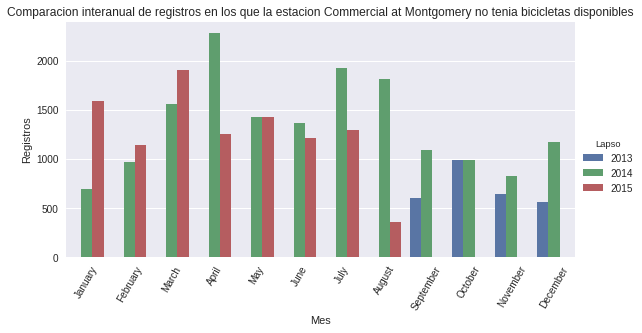

In [216]:
#Pruebo Commercial at Montgomery, que habia dado como al estación con más registros de quedarse sin bicicletas
stationToPlot = 45
plotEmptyStationEvents(stationToPlot)

In [217]:
#Comparación mes a mes
monthlyFrec = emptyStationDf.groupby(['month', 'year']).size()
monthlyFrec.name = 'count'
monthlyFrec = monthlyFrec.reset_index()
monthlyFrec.head(2)

,month,year,count
0,1,2014,14249
1,1,2015,20789


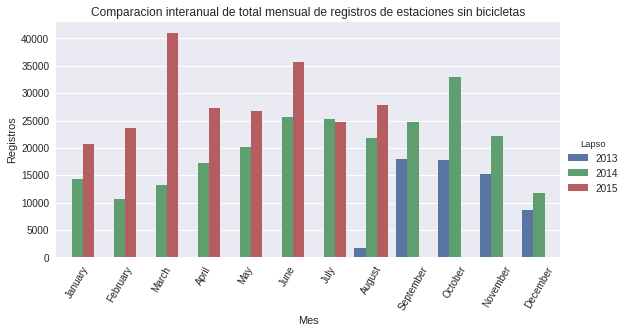

In [218]:
monthlyFrec['date'] = monthlyFrec.apply(lambda x : date(x.year, x.month, 1), axis=1)
monthlyFrec['year-month'] = monthlyFrec['date'].map(lambda x: x.strftime('%Y-%m'))
monthlyFrec['month_name'] = monthlyFrec['date'].map(lambda x: x.strftime('%B'))
monthlyFrec.set_index(monthlyFrec['date'], inplace=True)
monthlyFrec = monthlyFrec.loc[:, ['count', 'year-month', 'year', 'month_name']]
monthlyFrec.rename(columns={'count':'Registros', 'month_name':'Mes', 'year':'Lapso'}, inplace=True)
monthlyFrec.reset_index(inplace=True)

g = sns.factorplot(x='Mes', y='Registros', hue='Lapso', data=monthlyFrec, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Comparacion interanual de total mensual de registros de estaciones sin bicicletas')
g.set_xticklabels(rotation=60)

# ¿Cuánto tiempo están inactivas las bicicletas?

Se analizará el uso cada bicicleta.

### ¿Cuántas bicicletas hay en el set de datos?

In [339]:
len(tripsDf.groupby('bike_id').size())

700

### ¿Cómo son los intervalos de inactividad de las bicicletas?

Análisis de inactividad hasta de estreno, y desde último uso

In [340]:
# Creo un set de datos con el primer y último viaje de cada bicicleta
bikes = tripsDf.groupby('bike_id').agg(['count']).reset_index().loc[:,['bike_id']]
firstLastByBike = []
for index, row in bikes.iterrows():
    bikeId = row['bike_id'].values[0]
    tripsPerBike = tripsDf[tripsDf['bike_id'] == bikeId]
    tripsPerBike = tripsPerBike.sort_values(by='start_date')
    firstTrip = tripsPerBike.iloc[0]['start_date']
    lastTrip = tripsPerBike.iloc[len(tripsPerBike)-1]['start_date']
    firstLastByBike.append([bikeId, firstTrip, lastTrip])

firstLastByBikeDf = pd.DataFrame.from_dict(firstLastByBike)
firstLastByBikeDf = firstLastByBikeDf.rename(columns= {0:'bike_id', 1:'first_trip', 2:'last_trip'})
firstLastByBikeDf.head(5)

,bike_id,first_trip,last_trip
0,9,2013-08-29 12:02:00,2015-08-17 10:11:00
1,10,2013-09-01 13:47:00,2015-08-31 18:03:00
2,11,2013-08-29 20:11:00,2015-07-03 11:11:00
3,12,2013-08-30 17:15:00,2015-08-23 16:23:00
4,13,2013-08-29 10:13:00,2015-08-31 21:01:00


In [341]:
firstLastByBikeDf.sort_values(by='first_trip').head(5)

,bike_id,first_trip,last_trip
267,288,2013-08-29 09:08:00,2015-08-31 23:26:00
295,316,2013-08-29 09:24:00,2013-09-07 23:03:00
296,317,2013-08-29 09:24:00,2015-08-31 19:42:00
300,321,2013-08-29 09:24:00,2015-08-31 16:38:00
301,322,2013-08-29 09:25:00,2015-08-31 08:54:00


In [342]:
firstLastByBikeDf.sort_values(by='first_trip').tail(5)

,bike_id,first_trip,last_trip
24,33,2014-05-04 13:42:00,2015-08-31 20:33:00
699,878,2014-05-20 16:31:00,2015-08-31 18:34:00
698,877,2014-05-20 17:07:00,2015-08-31 20:36:00
697,876,2014-05-22 10:20:00,2014-05-27 07:30:00
696,740,2015-06-15 08:25:00,2015-06-29 06:24:00


In [343]:
#Agrego columnas con información de tiempo hasta el primer viaje, y tiempo desde el último
firstDay = date(2013, 8, 29)
firstLastByBikeDf['time_to_first'] = firstLastByBikeDf['first_trip'].map(lambda x: x.date() - firstDay)
firstLastByBikeDf['days_to_first'] = firstLastByBikeDf['time_to_first'].map(lambda x: x.days)

lastDay = date(2015, 8, 31)
firstLastByBikeDf['time_since_last'] = firstLastByBikeDf['last_trip'].map(lambda x: lastDay - x.date())
firstLastByBikeDf['days_since_last'] = firstLastByBikeDf['time_since_last'].map(lambda x: x.days)

In [344]:
firstLastByBikeDf.head(5)

,bike_id,first_trip,last_trip,time_to_first,days_to_first,time_since_last,days_since_last
0,9,2013-08-29 12:02:00,2015-08-17 10:11:00,0 days,0,14 days,14
1,10,2013-09-01 13:47:00,2015-08-31 18:03:00,3 days,3,0 days,0
2,11,2013-08-29 20:11:00,2015-07-03 11:11:00,0 days,0,59 days,59
3,12,2013-08-30 17:15:00,2015-08-23 16:23:00,1 days,1,8 days,8
4,13,2013-08-29 10:13:00,2015-08-31 21:01:00,0 days,0,0 days,0


In [345]:
firstLastByBikeDf.sort_values(by='time_to_first', ascending=False).head(5)

,bike_id,first_trip,last_trip,time_to_first,days_to_first,time_since_last,days_since_last
696,740,2015-06-15 08:25:00,2015-06-29 06:24:00,655 days,655,63 days,63
697,876,2014-05-22 10:20:00,2014-05-27 07:30:00,266 days,266,461 days,461
699,878,2014-05-20 16:31:00,2015-08-31 18:34:00,264 days,264,0 days,0
698,877,2014-05-20 17:07:00,2015-08-31 20:36:00,264 days,264,0 days,0
24,33,2014-05-04 13:42:00,2015-08-31 20:33:00,248 days,248,0 days,0


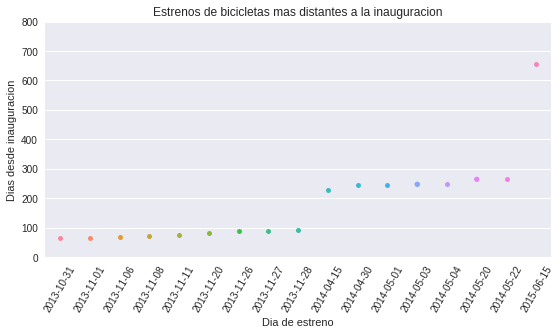

In [346]:
plotDf = firstLastByBikeDf.sort_values(by='days_to_first', ascending=False).head(20)
plotDf['day'] = plotDf['first_trip'].map(lambda x: x.date())
plotDf.sort_values(by='day', inplace=True)
plotDf.rename(columns={'day':'Dia de estreno', 'days_to_first':'Dias desde inauguracion'}, inplace=True)
g = sns.factorplot(x='Dia de estreno', y='Dias desde inauguracion', data=plotDf, kind = 'strip', size=4, aspect = 2)
g.axes.flat[0].set_title('Estrenos de bicicletas mas distantes a la inauguracion')
g.axes.flat[0].set(ylim=(0, 800))
g.set_xticklabels(rotation=60)

In [347]:
firstLastByBikeDf.sort_values(by='time_since_last', ascending=False).head(5)

,bike_id,first_trip,last_trip,time_to_first,days_to_first,time_since_last,days_since_last
454,476,2013-08-29 11:15:00,2013-09-07 17:37:00,0 days,0,723 days,723
438,460,2013-08-29 13:43:00,2013-09-07 13:55:00,0 days,0,723 days,723
302,323,2013-08-30 08:59:00,2013-09-07 18:13:00,1 days,1,723 days,723
543,565,2013-08-29 13:45:00,2013-09-07 14:35:00,0 days,0,723 days,723
295,316,2013-08-29 09:24:00,2013-09-07 23:03:00,0 days,0,723 days,723


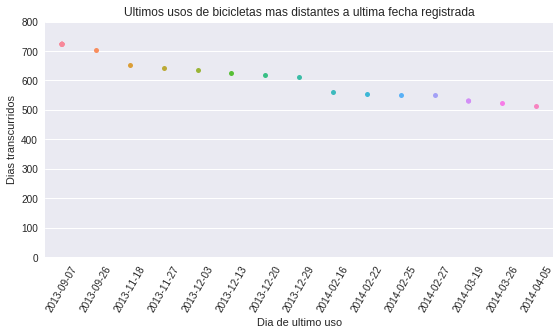

In [348]:
plotDf = firstLastByBikeDf.sort_values(by='days_since_last', ascending=False).head(20)
plotDf['day'] = plotDf['last_trip'].map(lambda x: x.date())
plotDf.sort_values(by='day', inplace=True)
plotDf.rename(columns={'day':'Dia de ultimo uso', 'days_since_last':'Dias transcurridos'}, inplace=True)
g = sns.factorplot(x='Dia de ultimo uso', y='Dias transcurridos', data=plotDf, kind = 'strip', size=4, aspect = 2)
g.axes.flat[0].set_title('Ultimos usos de bicicletas mas distantes a ultima fecha registrada')
g.axes.flat[0].set(ylim=(0, 800))
g.set_xticklabels(rotation=60)

Analizo la cantidad de bicicletas inactivas considerando distintos rangos de inactividad

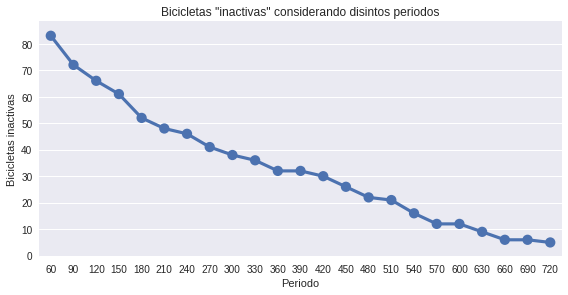

In [364]:
daysRange = range(0, 723, 30)
inactiveBikes = []
for i in daysRange:
    inactiveCount = len(firstLastByBikeDf[firstLastByBikeDf['days_since_last'] > i])
    inactiveBikes.append(inactiveCount)

    
inactiveBikesDf = pd.DataFrame(data={'Periodo':pd.Series(data=list(daysRange)), 'Bicicletas inactivas':pd.Series(data=inactiveBikes)})

g = sns.factorplot(x='Periodo', y='Bicicletas inactivas', data=inactiveBikesDf[inactiveBikesDf['Periodo'] > 30], size=4, aspect = 2)
g.axes.flat[0].set_title('Bicicletas "inactivas" considerando disintos periodos')


### ¿Cuál es el tiempo inactividad promedio hasta la última fecha dada?  

In [368]:
firstLastByBikeDf['time_since_last'].mean()

Timedelta('42 days 03:05:08.571428')